In [9]:
import dlib
import cv2
import os
import glob
from preprocessing.scarpping_component import extract_component_by_images

# Initialize dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Hapus Semua File Hasil Test
files = glob.glob('hasil_test/*')
for f in files:
    os.remove(f)

# Define component setup
components_setup = {
    'mulut': {
        'object_name': 'mouth',
        'object_rectangle': {"x_right": 54, "x_left": 48, "y_highest": 52, "y_lowest": 57},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 5},
        'object_dimension': {'width': 140, 'height': 40}
    },
    'mata_kiri': {
        'object_name': 'eye_left',
        'object_rectangle': {"x_right": 39, "x_left": 36, "y_highest": 38, "y_lowest": 41},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 25},
        'object_dimension': {'width': 90, 'height': 55}
    },
    'mata_kanan': {
        'object_name': 'eye_right',
        'object_rectangle': {"x_right": 45, "x_left": 42, "y_highest": 43, "y_lowest": 47},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 25},
        'object_dimension': {'width': 90, 'height': 55}
    },
    'alis_kiri': {
        'object_name': 'eyebrow_left',
        'object_rectangle': {"x_right": 21, "x_left": 17, "y_highest": 18, "y_lowest": 21},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 15},
        'object_dimension': {'width': 110, 'height': 40}
    },
    'alis_kanan': {
        'object_name': 'eyebrow_right',
        'object_rectangle': {"x_right": 26, "x_left": 22, "y_highest": 25, "y_lowest": 22},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 15},
        'object_dimension': {'width': 110, 'height': 40}
    },
    'hidung_kanan': {
        'object_name': 'nose_right',
        'object_rectangle': {"x_right": 31, "x_left": 40, "y_highest": 40, "y_lowest": 48},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": -25},
        'object_dimension': {'width': 70, 'height': 40}
    },
    'hidung_kiri': {
        'object_name': 'nose_left',
        'object_rectangle': {"x_right": 47, "x_left": 35, "y_highest": 47, "y_lowest": 54},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": -25},
        'object_dimension': {'width': 70, 'height': 40}
    }
}

def create_blocks(image, block_size):
    h, w = image.shape[:2]
    block_number = 1

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if x + block_size <= w and y + block_size <= h:
                cv2.rectangle(image, (x, y), (x + block_size, y + block_size), (0, 255, 0), 1)
                cv2.putText(image, str(block_number), (x + 2, y + 12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                block_number += 1
    return image

# Load image
# image_path = 'images/cina.jpg'

# image_path = 'dataset/casme_custom_from_one/Surprise/05_EP03_06/img2.jpg'

# image_path = 'dataset/casme_custom_from_one/Happiness/05_EP03_01/img50.jpg'
image_path = 'dataset/casme_custom_from_one/Happiness/05_EP03_01/img1.jpg'


image = cv2.imread(image_path)
if image is None:
    print(f"Error loading image from path: {image_path}")
else:
    # Resize image
    image = cv2.resize(image, (600, 500))
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Detect faces
    rects = detector(gray)

    if len(rects) == 0:
        print("No faces detected.")
    else:
        for rect in rects:
            # Draw rectangle around the face
            cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
            
            # Predict facial landmarks
            shape = predictor(gray, rect)

            for component_name, component_info in components_setup.items():
                print(f"\nProcessing {component_info['object_name']}")

                # Extract component by image
                data_blocks_image_current = extract_component_by_images(
                    image=image,
                    shape=shape,
                    frameName=component_name,
                    objectName=component_info['object_name'],
                    objectRectangle=component_info['object_rectangle'],
                    pixelShifting=component_info['pixel_shifting'],
                    objectDimension=component_info['object_dimension']
                )

                # Without blocks
                output_path = f'hasil_test/{component_info["object_name"]}.jpg'
                cv2.imwrite(output_path, data_blocks_image_current)
                print(f"Image without blocks saved at: {output_path}")

                # Resize component image
                scale_factor = 5  # Increase size by 5 times
                resized_component_image = cv2.resize(data_blocks_image_current, 
                                                     (data_blocks_image_current.shape[1] * scale_factor, 
                                                      data_blocks_image_current.shape[0] * scale_factor))

                # Create 5x5 blocks for the resized component image
                block_size = 5 * scale_factor  # Adjust block size according to the scale factor
                component_image_with_blocks = create_blocks(resized_component_image, block_size)

                # Save the result
                output_path = f'hasil_test/{component_info["object_name"]}_with_blocks.jpg'
                cv2.imwrite(output_path, component_image_with_blocks)

                # ukuran gambar
                print(f"Ukuran gambar: {image.shape[1]} x {image.shape[0]}")

                # debug
                # print landamark yang digunakan dalam setiap component
                # print(f"Landmark yang digunakan dalam {component_info['object_name']}:")
                # for key, value in component_info['object_rectangle'].items():
                #     print(f"{key}: {value}")

                print(f"Image with blocks saved at: {output_path}")

                object_rectangle = component_info['object_rectangle']
                pixel_shifting = component_info['pixel_shifting']
                object_dimension = component_info['object_dimension']
                
                # Setup shape part dari parameter objectRectangle
                x_right = shape.part(object_rectangle["x_right"]).x
                x_left = shape.part(object_rectangle["x_left"]).x
                y_highest = shape.part(object_rectangle["y_highest"]).y
                y_lowest = shape.part(object_rectangle["y_lowest"]).y

                print(f"x_right: {x_right}, x_left: {x_left}, y_highest: {y_highest}, y_lowest: {y_lowest}")
                
                # Setup shape part dari parameter pixelShifting
                # Menggeser tepi kiri sisi gambar sebanyak variabel pixel_shifting ke kiri
                x_left -= pixel_shifting["pixel_x"]
                # Menggeser tepi atas sisi gambar sebanyak variabel pixel_shifting ke atas
                y_highest -= pixel_shifting["pixel_y"]
                
                # Memastikan koordinat tetap berada dalam batas size gambar
                x_left = max(0, x_left)
                y_highest = max(0, y_highest)
                width_object = min(object_dimension["width"], image.shape[1] - x_left)
                height_object = min(object_dimension["height"], image.shape[0] - y_highest)

                
                # Draw the rectangle of the component on the original image
                cv2.rectangle(gray_bgr, (x_left, y_highest),
                            (x_left + width_object, y_highest + height_object),
                            (0, 0, 255), 2)
                
                # print koordinat cv2.rectangle
                print(f"x_left: {x_left}, y_highest: {y_highest}, width_object: {width_object}, height_object: {height_object}")
                
        # Save image with face detection and components rectangles for debugging
        debug_image_path = 'hasil_test/detected_faces_with_components.jpg'

        # Masking tiap landmark
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            cv2.circle(gray_bgr, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(gray_bgr, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

        cv2.imwrite(debug_image_path, gray_bgr)
        print(f"Image with face detection and components saved at: {debug_image_path}")
        print("Processing completed.")



Processing mouth
width_object: 140, height_object: 40
Image without blocks saved at: hasil_test/mouth.jpg
Ukuran gambar: 600 x 500
Image with blocks saved at: hasil_test/mouth_with_blocks.jpg
x_right: 322, x_left: 237, y_highest: 365, y_lowest: 396
x_left: 212, y_highest: 360, width_object: 140, height_object: 40

Processing eye_left
width_object: 90, height_object: 55
Image without blocks saved at: hasil_test/eye_left.jpg
Ukuran gambar: 600 x 500
Image with blocks saved at: hasil_test/eye_left_with_blocks.jpg
x_right: 247, x_left: 202, y_highest: 243, y_lowest: 251
x_left: 177, y_highest: 218, width_object: 90, height_object: 55

Processing eye_right
width_object: 90, height_object: 55
Image without blocks saved at: hasil_test/eye_right.jpg
Ukuran gambar: 600 x 500
Image with blocks saved at: hasil_test/eye_right_with_blocks.jpg
x_right: 367, x_left: 322, y_highest: 248, y_lowest: 259
x_left: 297, y_highest: 223, width_object: 90, height_object: 55

Processing eyebrow_left
width_obje

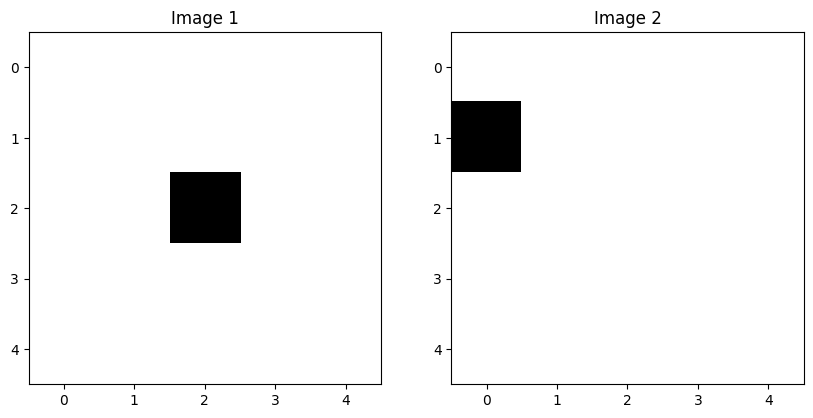

Hasil POC :
 Blok ke-1:
POC Value:
[[8.90255638e-17 2.29594371e-17 4.21884749e-17 1.25086055e-16
  9.37754060e-17]
 [1.00000000e+00 2.77555756e-17 8.32667268e-17 8.32667268e-17
  1.11022302e-16]
 [4.55109606e-17 1.57577450e-16 1.77635684e-16 4.42109604e-17
  1.07576076e-16]
 [2.01340542e-17 1.26322069e-17 1.24344979e-16 5.49444230e-17
  6.18987084e-17]
 [4.13346950e-17 3.13722453e-17 8.65973959e-17 9.97105478e-17
  2.52022102e-17]]
Koordinat Awal: [5. 5.]
Rectangle: [0. 0. 5. 5.]

Hasil Vektor : [[ 2.  2. -2. -1. -2.  1.]]
Hasil Quadran : [['0' -2 1 153.435 2.236 'Q2']]
Nilai Fitur Dataset {'X1': -2, 'Y1': 1, 'Tetha1': 153.435, 'Magnitude1': 2.236}


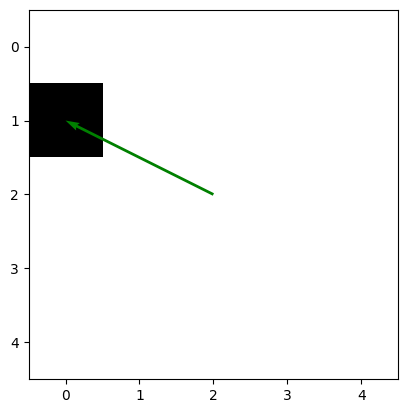

In [6]:
# Extraction Feature POC, Vektor, Quadran Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran


# Create two 5x5 pixel images with all white pixels
image1 = np.ones((5, 5), dtype=np.uint8) * 255
image2 = np.ones((5, 5), dtype=np.uint8) * 255

# Set one black pixel in image1
image1[2, 2] = 0

# Randomly select a position for the black pixel in image2
new_position = (np.random.randint(5), np.random.randint(5))

# Set the black pixel in the new position
image2[new_position] = 0

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')

plt.show()


# Inisiasi class POC
initPOC = POC(image1, image2, 5)
# Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
valPOC = initPOC.getPOC() 

# Format hasil POC agar lebih manusiawi
formatted_poc = '\n'.join([f"Blok ke-{i+1}:\nPOC Value:\n{valPOC[0][:,:,i]}\nKoordinat Awal: {valPOC[1][i]}\nRectangle: {valPOC[2][i]}\n" for i in range(valPOC[0].shape[2])])

print('Hasil POC :\n', formatted_poc)

# Pemanggilan class dan method untuk menampilkan quiver / gambar panah
initQuiv = Vektor(valPOC, 5)
quivData = initQuiv.getVektor() 
print('Hasil Vektor :', quivData)

# Quadran
initQuadran = Quadran(quivData) 
quadran = initQuadran.getQuadran()

print('Hasil Quadran :' , quadran)

frame_data = {}

for i, quad in enumerate(quadran):
        # --- Setup bagian Nilai Fitur Dataset ---
        # Set data kedalam frame_data sesuai column nya
        frame_data[f'X{i+1}'] = quad[1]
        frame_data[f'Y{i+1}'] = quad[2]
        frame_data[f'Tetha{i+1}'] = quad[3]
        frame_data[f'Magnitude{i+1}'] = quad[4]

print("Nilai Fitur Dataset", frame_data)


# Menampilkan gambar dengan quiver
plt.imshow(np.uint8(image2), cmap='gray')
plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="g")
plt.show()

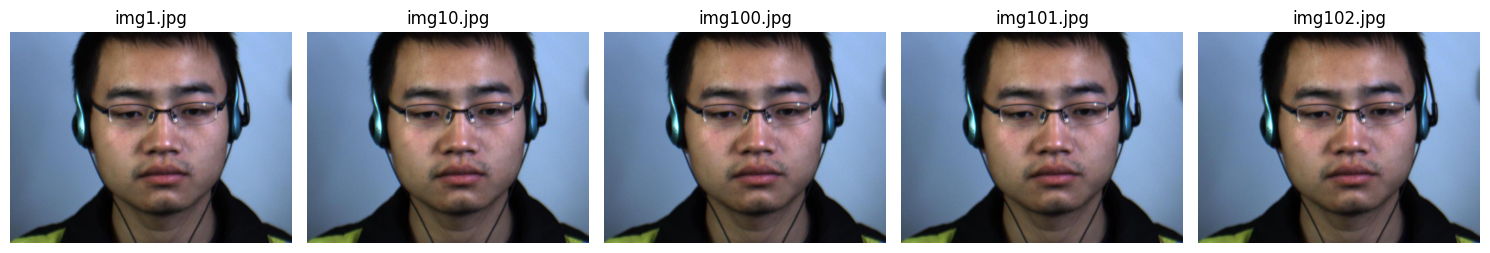

In [44]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing the images
directory = 'dataset/CASME2/CASME2/Happiness/Video_Image_RAW 200fps/06_EP01_01'

# Get a list of files in the directory
files = os.listdir(directory)

# Sort the files to ensure correct order
files.sort()

# Select the top 5 image files
top_files = files[:5]

# Load the images
images = [Image.open(os.path.join(directory, file)) for file in top_files]

# Plot the images in a grid
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for ax, img, file in zip(axs, images, top_files):
    ax.imshow(img)
    ax.set_title(file)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [85]:
import cv2
import os
import pandas as pd

# Fungsi untuk mendapatkan durasi video dan total frame
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()
    return duration, frame_count

# Data yang diberikan
data = {
    "Label": ["disgust", "disgust", "disgust", "disgust", "disgust", "disgust", "disgust",
              "happiness", "happiness", "happiness", "happiness", "happiness", "happiness", "happiness",
              "sadness", "sadness", "sadness", "sadness", "sadness", "sadness", "sadness",
              "surprise", "surprise", "surprise", "surprise", "surprise", "surprise", "surprise"],
    "Nama File": ["03_EP19_08", "17_EP13_04", "19_EP16_02", "20_EP06_03", "24_EP02_02f", "25_EP09_02", "25_EP18_04f",
                  "01_EP02_01f", "05_EP03_01", "06_EP01_01", "09_EP05_05", "09_EP15_05", "14_EP09_03", "17_EP06_07",
                  "17_EP15_01", "17_EP15_03", "19_EP19_04", "24_EP07_01", "24_EP07_04f", "24_EP10_03", "26_EP15_01",
                  "02_EP14_01", "05_EP03_06", "05_EP04_05", "05_EP12_03f", "06_EP02_31", "19_EP19_02", "24_EP18_03"]
}

# Menghitung jumlah data label dan nama file
data_count = len(data["Label"])

# Inisiasi list untuk menyimpan durasi video dan total frame
durations = []
total_frames = []

# Loop untuk mendapatkan durasi video dan total frame
for i in range(data_count):
    # Mendapatkan path video
    video_path = f'dataset/CASME2/CASME2/{data["Label"][i].capitalize()}/Video_Image_RAW 200fps/{data["Nama File"][i]}.avi'

    # Memeriksa apakah file video ada
    if os.path.exists(video_path):
        # Mendapatkan durasi video dan total frame
        duration, frame_count = get_video_info(video_path)
        # Memperbaiki tulisan durasi video dengan presisi tinggi tapi masih mudah dibaca
        duration = f"{duration:.2f} detik" if duration is not None else None
        durations.append(duration)
        total_frames.append(frame_count)
    else:
        durations.append(None)
        total_frames.append(None)
        print(f"Video Path: {video_path} - File tidak ditemukan")

# Menambahkan durasi dan total frame ke data
data["Durasi"] = durations
data["Total Frame"] = total_frames

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menyimpan DataFrame ke file Excel
output_file = 'hasil_durasi_video_dan_total_frame.xlsx'
df.to_excel(output_file, index=False)

print(f"Data durasi video dan total frame telah disimpan di {output_file}")


Data durasi video dan total frame telah disimpan di hasil_durasi_video_dan_total_frame.xlsx


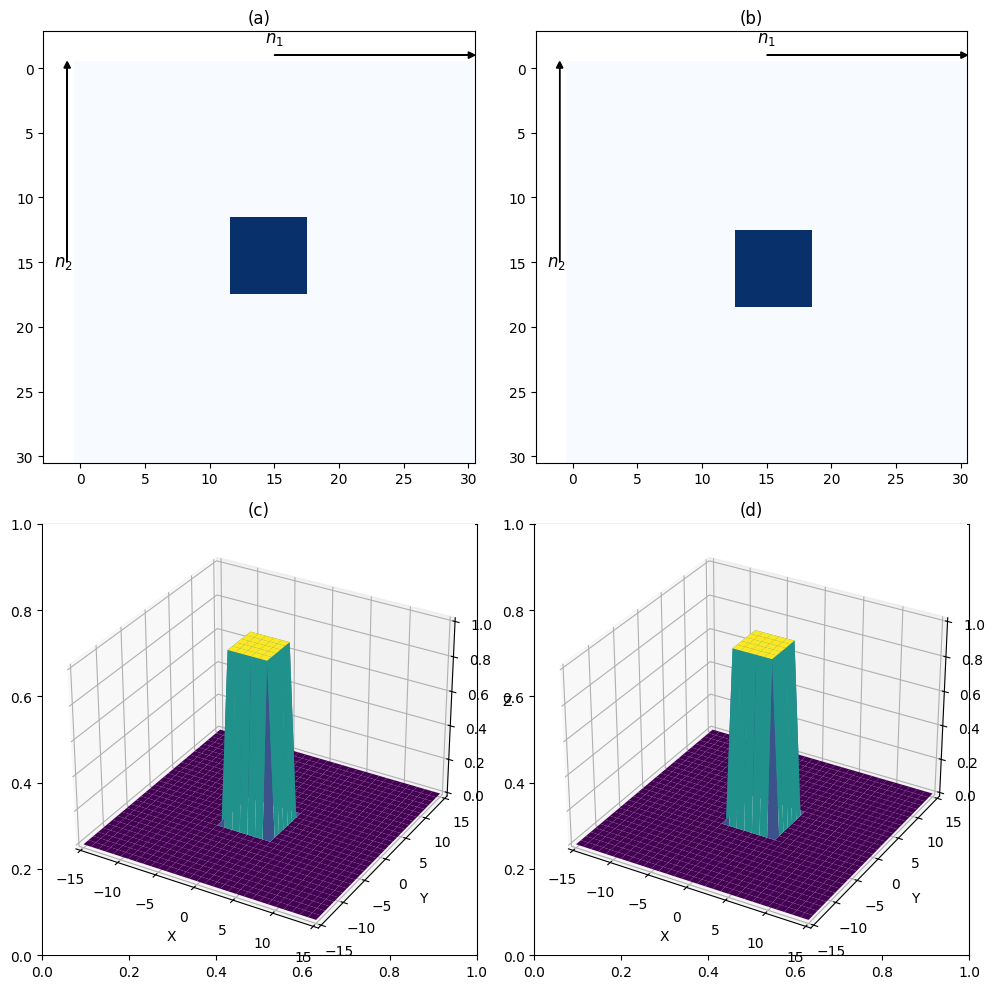

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
size = 31
half_size = size // 2

# Create an empty grid and a grid with a shifted square
grid = np.zeros((size, size))
shifted_grid = np.zeros((size, size))

# Define the square dimensions and initial position
square_size = 6
start = half_size - square_size // 2
end = start + square_size

# Add a square in the middle of the grid
grid[start:end, start:end] = 1

# Shift the square to the right and down by 1 pixel
shift_x, shift_y = 1, 1
shifted_grid[start + shift_y:end + shift_y, start + shift_x:end + shift_x] = 1

# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the grids as images
axs[0, 0].imshow(grid, cmap='Blues', interpolation='nearest')
axs[0, 0].set_title('(a)')
axs[0, 0].arrow(-1, half_size, 0, -half_size, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 0].arrow(half_size, -1, half_size, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 0].text(-2, half_size, r'$n_2$', fontsize=12, verticalalignment='center')
axs[0, 0].text(half_size, -2, r'$n_1$', fontsize=12, horizontalalignment='center')

axs[0, 1].imshow(shifted_grid, cmap='Blues', interpolation='nearest')
axs[0, 1].set_title('(b)')
axs[0, 1].arrow(-1, half_size, 0, -half_size, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 1].arrow(half_size, -1, half_size, 0, head_width=0.5, head_length=0.5, fc='black', ec='black')
axs[0, 1].text(-2, half_size, r'$n_2$', fontsize=12, verticalalignment='center')
axs[0, 1].text(half_size, -2, r'$n_1$', fontsize=12, horizontalalignment='center')

# Plot the 3D surface plots
X, Y = np.meshgrid(np.arange(size) - half_size, np.arange(size) - half_size)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot_surface(X, Y, grid, cmap='viridis', edgecolor='none')
ax3.set_title('(c)')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_xlim(-half_size, half_size)
ax3.set_ylim(-half_size, half_size)
ax3.set_zlim(0, 1)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot_surface(X, Y, shifted_grid, cmap='viridis', edgecolor='none')
ax4.set_title('(d)')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_xlim(-half_size, half_size)
ax4.set_ylim(-half_size, half_size)
ax4.set_zlim(0, 1)

# hapus grid plt
# for ax in axs.flatten():
#     ax.axis('off')

plt.tight_layout()
plt.show()


Hasil POC : [array([[[1.09227918e-01, 1.08869910e-02, 4.88887124e-02, ...,
         2.65704179e-01, 1.57857935e-01, 1.98013485e-01],
        [5.70658896e-02, 2.76214112e-01, 4.34062692e-02, ...,
         9.02856660e-02, 2.20633557e-01, 2.06041452e-01],
        [6.09763755e-02, 7.44744394e-02, 1.18123134e-01, ...,
         2.15881849e-02, 2.45059569e-02, 1.94619690e-01],
        [2.37432680e-01, 6.96301249e-03, 4.77220024e-02, ...,
         6.00967391e-02, 3.09180354e-01, 1.54419368e-01],
        [4.79772400e-02, 2.03488250e-02, 8.65375118e-02, ...,
         1.61629448e-01, 9.96692446e-02, 1.84427899e-01]],

       [[1.56282623e-01, 1.54561792e-01, 1.40670398e-01, ...,
         5.82249254e-02, 2.81312008e-02, 1.10766788e-01],
        [3.58816846e-01, 1.19148299e-01, 5.19145630e-02, ...,
         2.97592951e-01, 1.92095308e-01, 1.65674949e-01],
        [5.73696474e-01, 8.33030021e-02, 8.44643247e-02, ...,
         1.62442514e-01, 2.55176772e-01, 4.11509114e-01],
        [7.52903857e-02, 

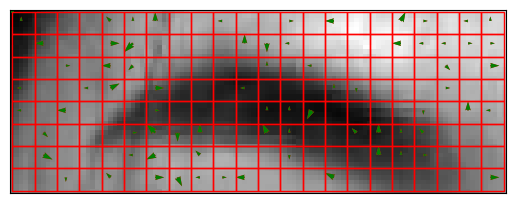

In [12]:
# Extraction Feature POC, Vektor, Quadran Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib.patches as patches
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran

# Load images
image1 = cv2.imread('temp/frame_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('temp/frame_50.jpg', cv2.IMREAD_GRAYSCALE)

# Inisiasi class POC
initPOC = POC(image1, image2, 5)
# Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
valPOC = initPOC.getPOC() 
print('Hasil POC :', valPOC)

# Pemanggilan class dan method untuk menampilkan quiver / gambar panah
initQuiv = Vektor(valPOC, 5)
quivData = initQuiv.getVektor() 
print('Hasil Vektor :', quivData)

# Quadran
initQuadran = Quadran(quivData) 
quadran = initQuadran.getQuadran()

print('Hasil Quadran :' , quadran)

plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="r")   

frame_data = {}

for i, quad in enumerate(quadran):
        # --- Setup bagian Nilai Fitur Dataset ---
        # Set data kedalam frame_data sesuai column nya
        frame_data[f'X{i+1}'] = quad[1]
        frame_data[f'Y{i+1}'] = quad[2]
        frame_data[f'Tetha{i+1}'] = quad[3]
        frame_data[f'Magnitude{i+1}'] = quad[4]

print("Nilai Fitur Dataset", frame_data)


# Menampilkan gambar dengan quiver
plt.imshow(np.uint8(image2), cmap='gray')
plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="g")

for rect_def in valPOC[2]:
        x, y, width, height = rect_def
        
        rects = patches.Rectangle((x,y), width,height, edgecolor='r', facecolor='none') 
        plt.gca().add_patch(rects)
        
        # plt.text(x,y,f'({num})', color="blue") 
        # num += 1

plt.axis('on') 
# plt.show() 

# hapus ruas x dan y
plt.xticks([])
plt.yticks([])
plt.show()